# Running on the Validate Split with Pre-trained Checkpoint

@Author: Juanwu Lu

Copyright &copy; 2024

In [1]:
from __future__ import annotations

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch

from src.data import (
    BaseData,
    INTERACTIONDataModule,
    INTERACTIONSubSampler,
    TargetCentricTransform,
    TargetReshapeTransform
)
from src.model import GNeVALightningModule

In [2]:
CKPT_ROOT = Path("../checkpoints/").resolve()
DATA_ROOT = Path("../data/").resolve()

In [3]:
# prepare dataset
dm = INTERACTIONDataModule(
    root=DATA_ROOT,
    challenge_type="single-agent",
    radius=None,
    subsampler=INTERACTIONSubSampler(
        locations=[
            # "DR_CHN_Merging_ZS0",
            # "DR_Merging_TR0",
            # "DR_USA_Intersection_MA",
            # "DR_Intersection_CM"
            # "DR_USA_Roundabout_SR",
            # "DR_Roundabout_RW",
            "DR_USA_Roundabout_FT",
        ],
    ),
    transform=[TargetCentricTransform(), TargetReshapeTransform()],
    batch_size=1,
    num_workers=8,
    enable_train=False,
    enable_val=True,
    enable_test=False,
    pin_memory=True,
)

In [4]:
ds = dm.val_dataset
dl = iter(dm.val_dataloader())

In [5]:
device = torch.device("cuda:0")
model = GNeVALightningModule.load_from_checkpoint(
    # NOTE: change the following checkpoint filepath accordingly
    CKPT_ROOT / "k_6_alpha_10.ckpt",
    map_location=device,
    strict=True
).eval()
network = model.network

In [11]:
data: BaseData = next(dl).to(device)
location, case_id, agent_id = ds._indexer[int(data.sample_idx)]
map_api = ds._map_api_container[location]
case_api = ds._track_api_container[location].get_case(case_id)
case_api.tracks_to_predict = data.tracks_to_predict

In [12]:
with torch.no_grad():
    # goal = data.y_motion[..., -1, 0:2]
    model = model.eval()

    output = model.forward(data=data)
    encoder_output = network.encoder.forward(data=data, need_weights=False)
    x_c = encoder_output["context_feats"]
    x_a = encoder_output["interaction_feats"]
    p_mu, p_kappa = network.decoder.generative_net.forward_mean()
    p_psi_tril, p_nu = network.decoder.generative_net.forward_precision()
    q_mu, q_kappa = network.decoder.inference_net.forward_mean(x=x_c)
    q_psi_tril, q_nu = network.decoder.inference_net.forward_precision(x=x_a)

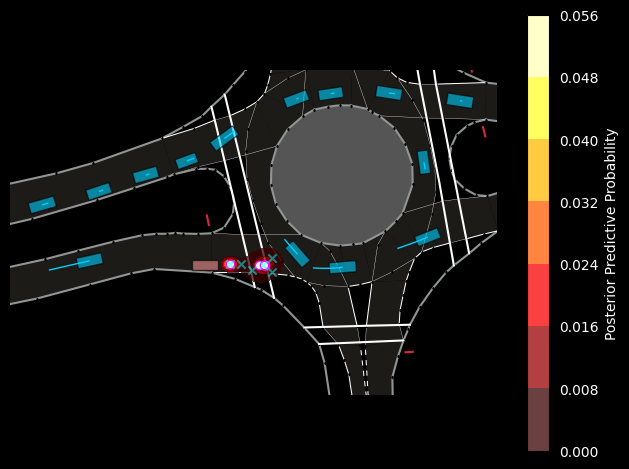

In [13]:
from src.model.decoder import get_posterior_predictive

fig, ax = plt.subplots(1, 1)

# plot the scenario
ax = map_api.render(
    anchor=data.anchor[0].cpu().numpy(),
    ax=ax,
    # radius=None
)
ax = case_api.render(
    anchor=data.anchor[0].cpu().numpy(),
    ax=ax,
    # plot_future=False,
)
fig.set_dpi(100)

# plot the prediction
ax.scatter(
    *output["intention"][0].cpu().numpy().T,
    c="cyan",
    marker="x",
    label="Sampled intention",
    alpha=0.5,
    zorder=43
)
# flag = False
# for i, conf in enumerate(output["confidence"][0].cpu().numpy()):
#     x, y = output["intention"][0, i].cpu().numpy()
#     ax.text(
#         x=x,
#         y=y,
#         s=f"{conf:.5f}",
#         fontsize=8,
#         ha="right",
#         va="bottom",
#         color="orange",
#         zorder=42
#     )
#     ax.plot(
#         *output["trajectory"][0, i].cpu().numpy().T,
#         c="orange",
#         label="Completed Trajectory" if not flag else None,
#         zorder=42,
#     )
#     flag = True

# plot the heatmap
# ax.scatter(
#     q_mu[..., 0].detach().cpu().numpy(),
#     q_mu[..., 1].detach().cpu().numpy(),
#     c="cyan",
#     marker="x",
#     label="Posterior Means",
#     zorder=40
# )
ax.scatter(
    q_mu[..., 0].detach().cpu().numpy(),
    q_mu[..., 1].detach().cpu().numpy(),
    ec="magenta",
    fc="white",
    marker="o",
    label="Prior Means",
    zorder=40,
)
ppd = get_posterior_predictive(
    psi=q_psi_tril.matmul(q_psi_tril.transpose(-1, -2)),
    nu=q_nu,
    mu=q_mu,
    beta=q_kappa
)

# Generate Random Samples
samples = ppd.sample((100,)).reshape(-1, 2)
# ax.scatter(
#     samples[..., 0].detach().cpu().numpy(),
#     samples[..., 1].detach().cpu().numpy(),
#     c="black",
#     marker=".",
#     label="Posterior Samples",
#     zorder=40
# )

_steps = torch.arange(
    0.0, 1.0, step=0.5 / 100, device=q_mu.device
)
xs: torch.FloatTensor = -30.0 + 100.0 * _steps[:, None]
ys: torch.FloatTensor = -20.0 + 40.0 * _steps[:, None]
samples = torch.stack(
    [
        xs.tile(dims=(200, 1)),
        ys.repeat_interleave(repeats=200, dim=0),
    ],
    dim=-1,
)
# z_logits = network.decoder._inference_net.forward_z(
#     value=samples,
#     posterior_psi=q_psi,
#     posterior_nu=q_nu,
#     posterior_mu=q_mu,
#     posterior_kappa=q_kappa,
# )
sample_probs = ppd.log_prob(samples[..., 0:2]).exp().mean(dim=-1)
# sample_probs = torch.sum(z_logits.exp() * sample_probs, dim=-1)

# ax.scatter(
#     goal[0, 0].item(),
#     goal[0, 1].item(),
#     ec="white",
#     fc="red",
#     marker="o",
#     label="Ground-truth Goal",
#     zorder=50
# )
sample_probs = np.ma.masked_less(sample_probs.cpu().numpy(), 5e-3)
cbar = ax.contourf(
    samples[..., 0].reshape(200, 200).cpu().numpy(),
    samples[..., 1].reshape(200, 200).cpu().numpy(),
    sample_probs.reshape(200, 200),
    alpha=0.75,
    cmap="hot",
    zorder=12,
)
cbar = ax.get_figure().colorbar(cbar, ax=ax, orientation="vertical")
cbar.ax.set_ylabel(
    "Posterior Predictive Probability",
    rotation=90,
    labelpad=5,
    fontdict={"color": "white"}
)
cbar.ax.set_yticklabels(
    cbar.ax.get_yticklabels(), fontdict={"color": "white"}
)

# ax.legend()
ax.set_xlim(-36, 54)
# ax.set_xlim(-24, 36)
# ax.set_xlim(-18, 27)
ax.set_ylim(-24, 36)
# ax.set_ylim(-16, 24)
# ax.set_ylim(-12, 18)
fig.tight_layout()